In [2]:
# Imports necessary libraries for data manipulation, machine learning, and plotting.
import numpy as np
import pandas as pd

# Imports specific modules for model selection, preprocessing, pipeline creation, SVC, and metrics.
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, classification_report
)

import matplotlib.pyplot as plt

# Sets a random state for reproducibility across different runs.
RANDOM_STATE = 42

In [3]:
# Imports the files module from google.colab to handle file uploads.
from google.colab import files
# asks to upload a file and stores the uploaded file.
uploaded = files.upload()

# Gets the name of the first uploaded file.
fname = next(iter(uploaded))
# Checks if the file has an .xlsx extension (case-insensitive).
if fname.lower().endswith('.xlsx'):
    # If it's an Excel file, reads it into a pandas DataFrame.
    df = pd.read_excel(fname)
# If it's not an Excel file, assumes it's a CSV and reads it into a pandas DataFrame.
else:
    df = pd.read_csv(fname)

# Prints the shape (number of rows, number of columns) of the DataFrame.
print(df.shape)
# Displays the first 5 rows of the DataFrame.
df.head()

Saving RF_ProjectProgress_CombinedDatasets_Subsets.xlsx to RF_ProjectProgress_CombinedDatasets_Subsets.xlsx
(1997, 10)


,freq1,noise,max_magnitude,total_gain_db,base_pwr_db,rssi,relpwr_db,avgpwr_db,Output,Source file
0,5805,-108,60,87,380,7,8,56,0,5ghz_activescan_background_loc1_1.csv
1,5805,-108,48,87,380,5,10,55,0,5ghz_activescan_background_loc1_1.csv
2,5805,-108,54,87,380,5,8,55,0,5ghz_activescan_background_loc1_1.csv
3,5805,-108,52,87,380,7,9,55,0,5ghz_activescan_background_loc1_1.csv
4,5805,-108,48,87,380,5,11,56,0,5ghz_activescan_background_loc1_1.csv


In [4]:
# Creates a copy of the DataFrame to avoid modifying the original 'df' loaded from file.
df = df.copy()

# Defines the column name that contains the labels (target variable).
LABEL_COL = 'Output'          # 0 for benign, 1 for malicious
# Defines a list of columns to be dropped from the dataset
DROP_COLS = ['Source file']   # text column,   removed to avoid leakage

# Iterates through each column in the DataFrame.
for c in df.columns:
    # Checks if the current column is not in the list of columns to be dropped.
    if c not in DROP_COLS:
        # Tries to convert the column to a numeric type,  errors to NaN.
        df[c] = pd.to_numeric(df[c], errors='ignore')

# Removes rows where the label column ('Output') has missing values (NaN).
df = df[~df[LABEL_COL].isna()]

# Placeholder for balancing and trimming data per class
CAP_PER_CLASS = None
# If a cap per class is defined, this block would balance the dataset.
if CAP_PER_CLASS is not None:
    parts = []
    for val, g in df.groupby(LABEL_COL):
        parts.append(g.sample(n=min(CAP_PER_CLASS, len(g)), random_state=RANDOM_STATE))
    df = pd.concat(parts).sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)

# Prints the shape of the DataFrame after cleaning.
print('After clean:', df.shape)
# Displays the first 5 rows of the cleaned DataFrame.
df.head()

After clean: (1997, 10)


/tmp/ipython-input-3906792838.py:14: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors='ignore')


,freq1,noise,max_magnitude,total_gain_db,base_pwr_db,rssi,relpwr_db,avgpwr_db,Output,Source file
0,5805,-108,60,87,380,7,8,56,0,5ghz_activescan_background_loc1_1.csv
1,5805,-108,48,87,380,5,10,55,0,5ghz_activescan_background_loc1_1.csv
2,5805,-108,54,87,380,5,8,55,0,5ghz_activescan_background_loc1_1.csv
3,5805,-108,52,87,380,7,9,55,0,5ghz_activescan_background_loc1_1.csv
4,5805,-108,48,87,380,5,11,56,0,5ghz_activescan_background_loc1_1.csv


In [5]:
INCLUDE_FREQ = True  # Flag to include or exclude 'freq1' from features. Will possibly set to False in the future to drop 'freq1' for a leakage check. Should make sure model isnt cheating.

# Initializes a set of columns to be dropped, starting with predefined DROP_COLS and the LABEL_COL.
drop_now = set(DROP_COLS + [LABEL_COL])

# If INCLUDE_FREQ is False and 'freq1' exists in the DataFrame, adds 'freq1' to the drop list.
if not INCLUDE_FREQ and 'freq1' in df.columns:
    drop_now.add('freq1')

# Identifies all numeric columns that are not in the 'drop_now' set.
numeric_cols = [c for c in df.columns
                if c not in drop_now and pd.api.types.is_numeric_dtype(df[c])]

# Creates the feature matrix X by selecting the numeric columns and making a copy.
X = df[numeric_cols].copy()
# Creates the target vector y by selecting the label column and converting it to integer type.
y = df[LABEL_COL].astype(int).copy()

# Prints the list of feature columns.
print('Feature columns:', numeric_cols)
# Prints the shape of the feature matrix X and the target vector y.
print('X shape:', X.shape, ' y shape:', y.shape)

Feature columns: ['freq1', 'noise', 'max_magnitude', 'total_gain_db', 'base_pwr_db', 'rssi', 'relpwr_db', 'avgpwr_db']
X shape: (1997, 8)  y shape: (1997,)


In [6]:
# Splits the dataset into training and testing sets.
# X: features, y: labels
# test_size=0.2: 20% of data for testing 80% for training.
# random_state: for reproducibility.
# stratify=y: ensures that the proportion of target variable 'y' is the same in both train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Prints the shapes of the training and testing feature sets.
X_train.shape, X_test.shape

((1597, 8), (400, 8))

In [7]:
# Creates a machine learning pipeline with two steps:
# 1. 'scaler': A StandardScaler for feature scaling.  checks for sparse data to apply appropriate scaling.
# 2. 'svc': A Support Vector Classifier (SVC) with probability estimates enabled and a fixed random state.
pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=False) if hasattr(X_train, 'sparse') and X_train.sparse else StandardScaler()),
    ('svc', SVC(probability=True, random_state=RANDOM_STATE))
])

# Defines the search space for hyperparameters for RandomizedSearchCV.
param_dist = {
    'svc__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],  # Different kernel types for SVC.
    'svc__C': np.logspace(-3, 3, 20),                     # Regularization parameter C in a logarithmic scale.
    'svc__gamma': ['scale', 'auto'] + list(np.logspace(-4, 1, 10)), # Kernel coefficient gamma.
    'svc__degree': [2, 3, 4],                             # Degree of the polynomial kernel.
}

# Sets up StratifiedKFold for cross-validation.
# n_splits=5: 5 folds.
# shuffle=True: shuffles data before splitting.
# random_state: for reproducibility.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Configures RandomizedSearchCV for hyperparameter optimization.
search = RandomizedSearchCV(
    estimator=pipe,                                   # The pipeline to optimize.
    param_distributions=param_dist,                   # The hyperparameter search space.
    n_iter=40,                                        # Number of parameter settings that are sampled.
    scoring='f1' if len(np.unique(y)) == 2 else 'f1_macro', # Metric to evaluate the model.
    cv=cv,                                            # Cross-validation strategy
    verbose=1,                                        # Controls the verbosity: the higher, the more messages.
    n_jobs=-1,                                        # Number of jobs to run in parallel.
    random_state=RANDOM_STATE,                        # for reproducibility.
    refit=True,                                       # Refit the best estimator on the whole dataset.
)

# Displays the configured RandomizedSearchCV object.
search

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svc',
                                              SVC(probability=True,
                                                  random_state=42))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'svc__C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377...
                                                       np.float64(0.00035938136638046257),
                                                       np.float64(0.001291549665014884),
                                                       np.float64(0.004641588833612782),
                                                       np.float64(0.016681005372000592),
                                                       np.float64(0.05994842503189409),
                                                       np.float64(0.21544346900318845),
                                                       np.float64(0.7742636826811278),
                                                       np.float64(2.782559402207126),
                                                       np.float64(10.0)],
                                        'svc__kernel': ['rbf', 'linear', 'poly',
                                                        'sigmoid']},
                   random_state=42, scoring='f1', verbose=1)

In [8]:
# Fits the RandomizedSearchCV object to the training data (X_train, y_train).
# This performs the hyperparameter search and trains the best model.
search.fit(X_train, y_train)

# Prints the best cross-validation score found during the search.
print("Best score:", search.best_score_)
# Prints the best hyperparameters found during the search.
print("Best params:", search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best score: 0.9881460760916113
Best params: {'svc__kernel': 'rbf', 'svc__gamma': np.float64(0.21544346900318845), 'svc__degree': 2, 'svc__C': np.float64(6.158482110660261)}


Accuracy: 0.985
Precision: [0.985 0.985]
Recall: [0.985 0.985]
F1: [0.985 0.985]

Classification report

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       200
           1       0.98      0.98      0.98       200

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



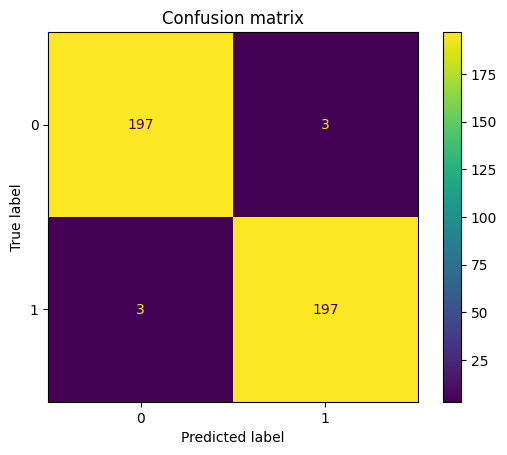

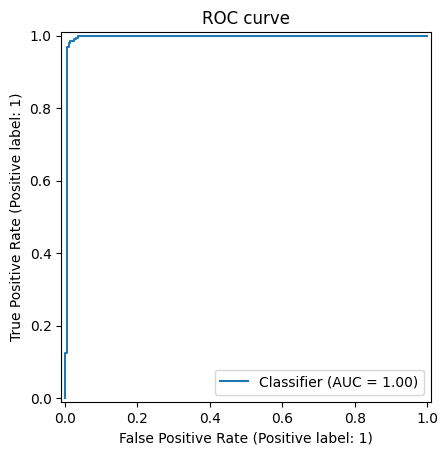

In [9]:
# Predicts the labels for the test set using the best model found by RandomizedSearchCV.
y_pred = search.predict(X_test)

# Initializes y_proba to None. This will store probability estimates for ROC curve.
y_proba = None
# Tries to get probability estimates for the positive class from the model.
try:
    y_proba = search.predict_proba(X_test)[:, 1]
except Exception:
    pass

# Determines the averaging method for metrics based on the number of unique classes in y_test.
avg = 'binary' if len(np.unique(y_test)) == 2 else 'macro'
# Prints the accuracy score.
print("Accuracy:", accuracy_score(y_test, y_pred))
# Prints the precision score.
print("Precision:", precision_score(y_test, y_pred, average=None if avg=='binary' else avg))
# Prints the recall score.
print("Recall:", recall_score(y_test, y_pred, average=None if avg=='binary' else avg))
# Prints the F1 score.
print("F1:", f1_score(y_test, y_pred, average=None if avg=='binary' else avg))
# Prints a classification report, which includes precision, recall, f1-score, and support for each class.
print("\nClassification report\n")
print(classification_report(y_test, y_pred))

# Generates the confusion matrix.
cm = confusion_matrix(y_test, y_pred)
# Creates a display object for the confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# Plots the confusion matrix.
disp.plot()
# Sets the title for the confusion matrix plot.
plt.title("Confusion matrix")
# Displays the plot.
plt.show()

# Checks if probability estimates are available and if it's a binary classification problem for ROC curve.
if y_proba is not None and len(np.unique(y_test)) == 2:
    # Plots the Receiver Operating Characteristic (ROC) curve.
    RocCurveDisplay.from_predictions(y_test, y_proba)
    # Sets the title for the ROC curve plot.
    plt.title("ROC curve")
    # Displays the plot.
    plt.show()